In [1]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

[ Info: Oceananigans will use 4 threads


In [2]:
runname = "default"
@inline function makesecondarycirculationvid(runname, i=nothing)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    ωfilename = "secondary_circulation.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)

    file = jldopen("$foldername/$filename")
    ωfile = jldopen("$foldername/$ωfilename")

    n = Observable(101)

    frame = @lift frames[$n]
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1

    b = @lift file["timeseries/b_dfm/$($frame)"][:, 1, :]
    ω = @lift ωfile["timeseries/ω/$($frame)"][:, 1, :] 
    ω_depth = @lift sqrt.(ωfile["timeseries/ω_depth/$($frame)"][1, 1, :])
    # Get the secondary cirulation streamfunction
    σ=3

    title = @lift "$runname, t = $(round(ts[$n]; digits=2))"
    
    axis_kwargs = (; xlabel="x", ylabel="z", title, limits=(-2, 0, -0.12, 0))

    fig = Figure(resolution=(1200, 600))
    fig[1, 1:3] = Label(fig, title, fontsize=20)
    axω = Axis(fig[2, 1]; title=L"\langle \omega \rangle", axis_kwargs...)
    axω_depth = Axis(fig[2, 3]; xlabel="RMS", ylabel="z", limits=(0, 10, -0.12, 0))
    
    ht1 = heatmap!(axω, xᶜᵃᵃ, zᵃᵃᶠ, ω; colormap=:balance, colorrange=(-10, 10))
    
    for ax in [axω]
        contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, b; color=(:black, 1), levels=range(-200, 200, 160), linewidth=1.5)
    end
    Colorbar(fig[2, 2], ht1, label=L"\omega")
    lines!(axω_depth, ω_depth, zᵃᵃᶠ)
    
    if i != nothing
        n[] = i
        return fig
    end
    
    vidfoldername = "output/videos/$runname/vorticity"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig; resolution=(1200, 600))
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    fig
end

makesecondarycirculationvid (generic function with 2 methods)

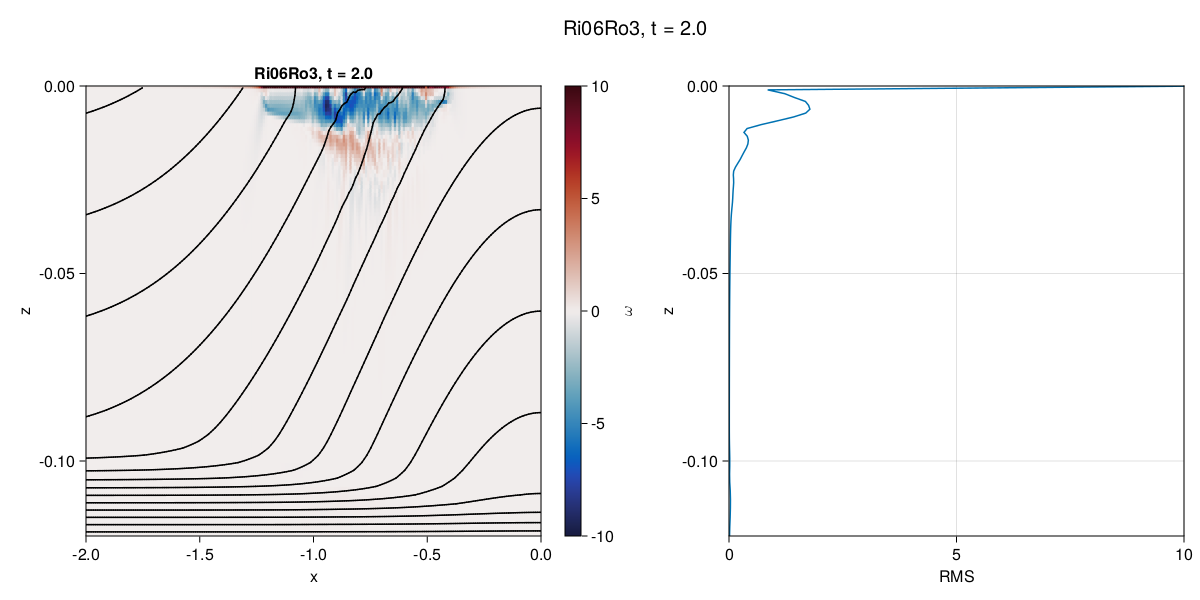

In [9]:
makesecondarycirculationvid("Ri06Ro3", 301)

In [4]:
runname = "default"
@inline function makesecondarycirculationtimeseries(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    ωfilename = "secondary_circulation.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶠ = grid.Δzᵃᵃᶠ[1:129]
    
    ωfile = jldopen("$foldername/$ωfilename")
    ω_depth = [sqrt(sum(sum(ωfile["timeseries/ω/$frame"][:, 1, :] .^ 2; dims=1)[1, 1, :] .* Δzᵃᵃᶠ) / sum(Δzᵃᵃᶠ)) for frame in frames]
    close(ωfile)
    return ω_depth
end

makesecondarycirculationtimeseries (generic function with 1 method)

In [5]:
runnames = ["Ri02Ro2", "Ri02Ro3", "Ri04Ro2", "Ri04Ro3", "Ri06Ro2", "Ri06Ro3", "Ri09Ro2", "Ri09Ro3", "Ri1Ro2", "Ri1Ro3", "Ri1Ro4", "Ri1Ro5"]
ω_depths = map(makesecondarycirculationtimeseries, runnames);

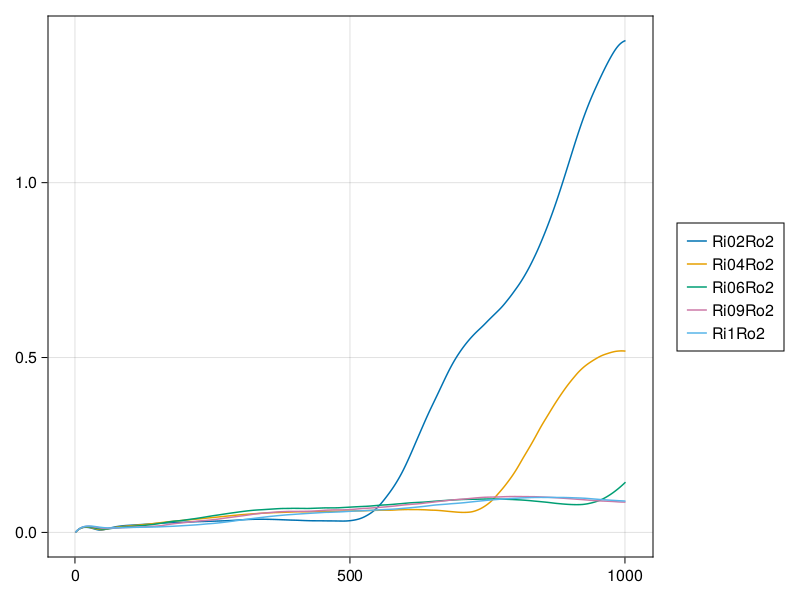

In [7]:
fig = Figure()
ax = Axis(fig[1, 1])
indices = [1, 3, 5, 7, 9]
lns = [lines!(ax, ω_depths[i][101:1101]) for i in indices]
Legend(fig[1, 2], lns, runnames[indices])
fig